# Import the modules

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Build the data we'll work on

In [15]:
df_price = pd.read_csv("../../../price_computed/price_filled2.csv", sep=";")

tab_price = df_price.to_numpy()[:,3:]
dates_tab = df_price.columns[2:].to_numpy(dtype = np.str)

header = df_price.columns # The header contains all the days for which we have data
print(f'Header of the dataframe \n{header}')
np_price = df_price.to_numpy()
print(f'Prices Numpy array (with products names) \n{np_price}')

Header of the dataframe 
Index(['Unnamed: 0', 'Produit', '2014-01-02', '2014-01-03', '2014-01-06',
       '2014-01-07', '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
       ...
       '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30',
       '2021-05-03', '2021-05-04', '2021-05-05', '2021-05-06', '2021-05-07'],
      dtype='object', length=1827)
Prices Numpy array (with products names) 
[[0 'ABRICOT Bergarouge France cat.I 45-50mm' 1.5 ... 1.8 1.8 1.8]
 [1 'ABRICOT Bergarouge France cat.I 50-55mm' 1.6 ... 2.3 2.3 2.3]
 [2 'ABRICOT Bergeron France cat.I 40-45mm' 1.25 ... 1.2 1.2 1.2]
 ...
 [753 'ÉCHALOTE France cat.I' 1.1 ... 4.3 4.3 4.3]
 [754 'ÉCHALOTE primeur France cat.I' 1.4 ... 1.8 1.8 1.8]
 [755 'ÉPINARD France cat.I' 1.9 ... 1.8 1.8 1.8]]


<ipython-input-15-4e244dc5939e>:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dates_tab = df_price.columns[2:].to_numpy(dtype = np.str)


In [16]:
# collecting the indexes of the first data of each month
current_month = dates_tab[0][:-3]
month_first_index = {current_month : 0}

for i in range(len(dates_tab)) :
    if (dates_tab[i][-4] != current_month[-1]) :
        current_month = dates_tab[i][:-3]
        month_first_index[current_month] = i

# averaging the price on each month
indexes = np.array(list(month_first_index.values()))
total = []
for i in range(len(month_first_index)-1) :
    X = tab_price[:,indexes[i]:indexes[i+1]].mean(axis = 1)
    total.append(X)
total.append(tab_price[:,indexes[-1]:].mean(axis = 1))
np_price = np.column_stack(total).T

Now we need to just keep the prices of our products

In [17]:
prices_monthly = np_price[:,2:]
n_samples, n_features = prices_monthly.shape
print(f"Prices array with a shape of {prices_monthly.shape}")

Prices array with a shape of (89, 754)


That big array will be useful at the end of the simulation. Now we need two samples : the training one and the test one.
First we have to exract the labels of our data : the CPI. Note that it's given to us only month by month from 2014 to 2021.

In [18]:
df_ipc = pd.read_csv("../valeurs_mensuelles.csv", sep = ";") #IPC

dates = df_ipc["Libellé"].to_numpy()[3:]
dates = dates[::-1].copy()

np_IPC = df_ipc[df_ipc.columns[1]].iloc[3:].to_numpy(dtype = np.float)[::-1]

IPC = np_IPC[-n_samples:]
IPC.shape

IPC_train = IPC[:int(len(IPC)*.8)] #IPCs used to learn
IPC_test = IPC[int(len(IPC)*.8):]  #IPCs used to test the model
print(f'Train label sample length : {len(IPC_train)}')
print(f'Test label sample length : {len(IPC_test)}')

Train label sample length : 71
Test label sample length : 18


<ipython-input-18-447a71b726a9>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np_IPC = df_ipc[df_ipc.columns[1]].iloc[3:].to_numpy(dtype = np.float)[::-1]


Then we need to extract the prices month by month. We proceed by average the daily prices over months.

Then we can preprocess our data, with a standard scaling.

In [19]:
scaler = StandardScaler()
scaler.fit(prices_monthly)
prices_monthly = scaler.transform(prices_monthly)

prices_train = np.array(prices_monthly[:len(IPC_train)])
prices_test = np.array(prices_monthly[len(IPC_train):])

Finally we define the processes to compute our predicitons and our plot. Here we use a grid search with cross validation over the parameter that we want to adjust. Then the process makes the best prediction that is possible with the given model.

In [20]:
def Prediction(model, parameter, variation_list):
    Model = model
    n_list = variation_list
    tuned_parameters = {parameter: n_list}
    nb_folds = 5
    grid = GridSearchCV(Model, tuned_parameters, cv=nb_folds, refit=True, scoring='neg_mean_squared_error')
    grid.fit(prices_train, IPC_train)
    print(f'Best model found : {grid.best_estimator_}')
    Model = grid.best_estimator_
    Predict_test = Model.predict(prices_test)
    Predict = Model.predict(prices_monthly)
    Predict_train = Model.predict(prices_train)
    
    RMSE_test = mean_squared_error(IPC_test, Predict_test, squared = False)
    RMSE_train = mean_squared_error(IPC_train, Predict_train, squared = False)

    print(f'RMSE on test set: {RMSE_test}')
    print(f'RMSE on train set: {RMSE_train}')

    return Predict, RMSE_test, RMSE_train

In [21]:
def Graph(prediction, real_values, model):
    plt.plot(Predict, label='Prediction')
    plt.plot(IPC, label='Real IPC')
    plt.xticks(list(range(89))[::10], [i for i in month_first_index.keys()][::10], rotation = 45)
    plt.grid()
    plt.legend()
    plt.title(f'Prediction attempt with {model}')
    plt.show()

First let's regession a linear regression.

Best model found : LinearRegression()
RMSE on test set: 13.460397370794828
RMSE on train set: 1.4605675811783635e-14


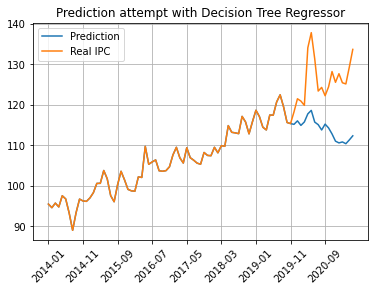

In [22]:
Predict, RMSE_test_Lreg, RMSE_trian_Lreg = Prediction(LinearRegression(), "fit_intercept", [True])
Graph(Predict, IPC, 'Decision Tree Regressor')

Let's test serveral types of regressions !

Best model found : DecisionTreeRegressor(max_depth=20)
RMSE on test set: 8.400039351759682
RMSE on train set: 0.0


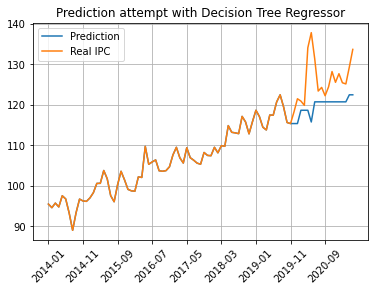

In [23]:
Predict, RMSE_test_DTR, RMSE_trian_DTR = Prediction(DecisionTreeRegressor(), 'max_depth', np.arange(5, 30, 1))
Graph(Predict, IPC, 'Decision Tree Regressor')

Best model found : KNeighborsRegressor(n_neighbors=2)
RMSE on test set: 10.95008885047667
RMSE on train set: 1.195308611219854


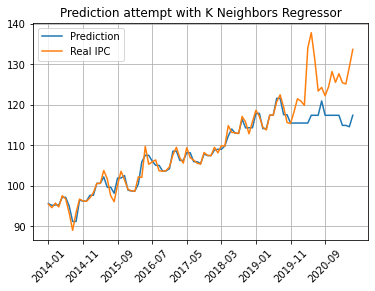

In [24]:
Predict, RMSE_test_kNN, RMSE_trian_kNN = Prediction(KNeighborsRegressor(), 'n_neighbors', np.arange(1, 30, 1))
Graph(Predict, IPC, 'K Neighbors Regressor')

In [38]:
Predict, RMSE_test_GBR0, RMSE_trian_GBR0 = Prediction(GradientBoostingRegressor(), 'n_estimators', np.arange(50, 500, 50))
Graph(Predict, IPC, 'Gradient Boosting Regressor')

KeyboardInterrupt: 

As we can see, even with the cross-validation process, we cannot make good predictions on CPI. However we just want to predict the next month CPI, so let's try to predict month by month, adding a re-learning at each month with grid searching over a few parameters. The tests will be done with Gradient Boosting Regression, which seems to be the best model for our problem.

In [ ]:
def Prediction_monthly_with_grid(model, parameters, variation_lists, test_labels, train_labels, test_features, train_features):
    Predict = train_labels
    rank = 1
    L = test_labels.shape[0]
    while rank < L:
        Model = model
        for parameter, variation_list in zip(parameters, variation_lists):
            n_list = variation_list
            tuned_parameters = {parameter: n_list}
            nb_folds = 5
            grid = GridSearchCV(Model, tuned_parameters, cv=nb_folds, refit=True, scoring='r2')
            grid.fit(prices_train, IPC_train.ravel())
            print(f'Best model found : {grid.best_estimator_}')
            Model = grid.best_estimator_
        Predict_one = Model.predict(test_features[0].reshape(1, -1))
        train_features = np.column_stack((train_features.T, test_features[0].T)).T
        test_features = test_features[1:]
        Predict = np.append(Predict, Predict_one)
        train_labels = np.append(train_labels, test_labels[0])
        test_labels = test_labels[1:]
        rank += 1
    return Predict

In [ ]:
parameters = ['n_estimators', 'alpha']
values = [np.arange(50, 500, 50), np.arange(0.1, 1.0, 0.1)]
Predict = (GradientBoostingRegressor(loss='quantile'), parameters, values, IPC_test, IPC_train, prices_test, prices_train)
print(Predict.shape)
Graph(Predict, IPC, 'Gradient Boosting Regressor monthly with double grid search\nQuantile loss')

In [ ]:
parameters = ['n_estimators', 'alpha']
values = [np.arange(50, 500, 50), np.arange(0.1, 1.0, 0.1)]
Predict = (GradientBoostingRegressor(loss='ls'), parameters, values, IPC_test, IPC_train, prices_test, prices_train)
print(Predict.shape)
Graph(Predict, IPC, 'Gradient Boosting Regressor monthly with double grid search\n LS loss')

The grid search is apparently not helping us that much. Let's build a simple progressive prediction function, with given parameters and test it on our Gradient Boosting Regressor. The parameters we'll use are those found in the quantile test notebook.

In [26]:
def Prediction_monthly(model, parameters, test_labels, train_labels, test_features, train_features):
    original_train_features, original_train_labels = train_features, train_labels
    Model = model(**parameters)
    Model.fit(train_features, train_labels)
    Predict = Model.predict(train_features)[:-1]
    rank = 1
    L = test_labels.shape[0]
    while rank < L+1:
        Model = model(**parameters)
        Model.fit(train_features, train_labels)
        Predict_one = Model.predict(test_features[0].reshape(1, -1))
        train_features = np.column_stack((train_features.T, test_features[0].T)).T
        test_features = test_features[1:]
        Predict = np.append(Predict, Predict_one)
        train_labels = np.append(train_labels, test_labels[0])
        test_labels = test_labels[1:]
        rank += 1

    Predict_train = Model.predict(original_train_features)
    Predict_test = Predict[-L:]

    RMSE_test = mean_squared_error(IPC_test, Predict_test, squared = False)
    RMSE_train = mean_squared_error(original_train_labels, Predict_train, squared = False)

    print(f'RMSE on test set: {RMSE_test}')
    print(f'RMSE on train set: {RMSE_train}')

    return Predict

RMSE on test set: 5.02392160918113
RMSE on train set: 1.7622510529237512e-05
(88,)


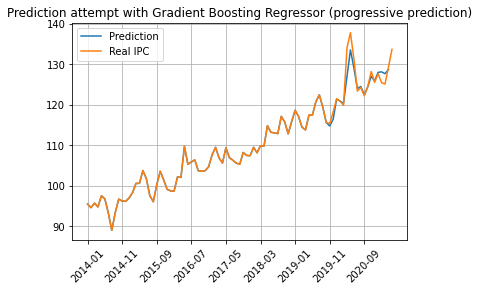

In [27]:
# best parameters based on a grid search
parameters = {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_split': 8, 'n_estimators': 150, 'alpha':0.5}
Predict = Prediction_monthly(GradientBoostingRegressor, parameters, IPC_test, IPC_train.ravel(), prices_test, prices_train)
print(Predict.shape)
Graph(Predict, IPC, 'Gradient Boosting Regressor (progressive prediction)')

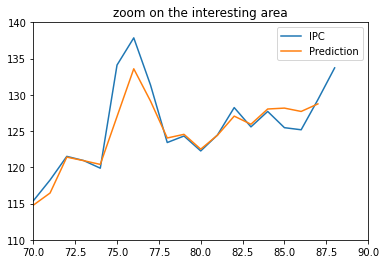

In [28]:
plt.plot(range(len(IPC)), IPC, label = "IPC")
plt.plot(range(len(Predict)), Predict, label = "Prediction")
plt.xlim(70,90)
plt.ylim(110, 140)
plt.title("zoom on the interesting area")
plt.legend()

# Impact of PCA (Principal Component Analysis)

As we can see up there, the result is pretty satisfying. However we can try to perfectionate the model. Let's try to make a Principal Component Analysis. The major coefficient to care about is the explained variance. We impose to explain at least 95% of it.

In [29]:
from sklearn.decomposition import PCA

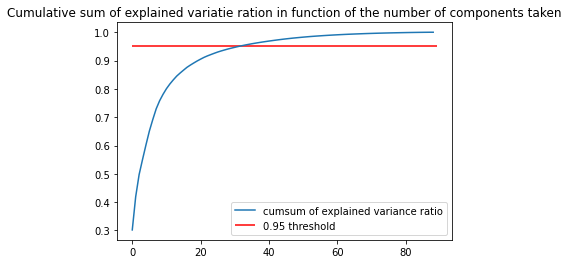

In [30]:

pca = PCA(n_components = min(n_samples, n_features))
pca.fit(prices_monthly)
cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(range(pca.n_components), cumsum, label = "cumsum of explained variance ratio")
plt.hlines(.95, 0, pca.n_components, color = "r", label = "0.95 threshold")
plt.title("Cumulative sum of explained variatie ration in function of the number of components taken")
plt.legend()

In [31]:
i = 0
while cumsum[i] < .95 :
    i += 1
print(f'With {i+1} samples we explain 95% of the result')

With 33 samples we explain 95% of the result


In [32]:
pca.set_params(n_components = 35)
pca.fit(prices_monthly)
print(f'Total explained variance {sum(list(pca.explained_variance_ratio_)):.3f}')

Total explained variance 0.957


In [33]:
prices_train_pca = pca.transform(prices_train)
prices_test_pca = pca.transform(prices_test)

RMSE on test set: 6.8345748104029616
RMSE on train set: 2.9506751248743547e-08
(88,)


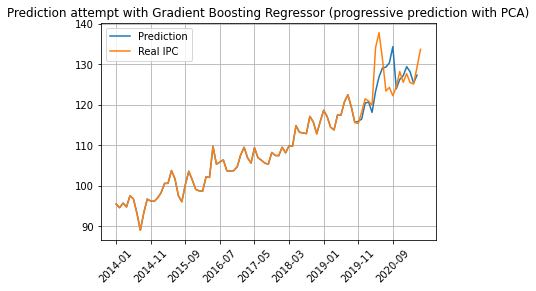

In [34]:
# best parameters based on a gridsearch
parameters = {'learning_rate': 0.05, 'max_depth': 6, 'min_samples_split': 6, 'n_estimators': 500} 
Predict = Prediction_monthly(GradientBoostingRegressor, parameters, IPC_test.ravel(), IPC_train.ravel(), prices_test_pca, prices_train_pca)
print(Predict.shape)
Graph(Predict, IPC, 'Gradient Boosting Regressor (progressive prediction with PCA)')

The quantile regression with PCA has the good magnitude but it is worst than without.

# What about regularized models ?

## L2 Regularisation : Ridge model

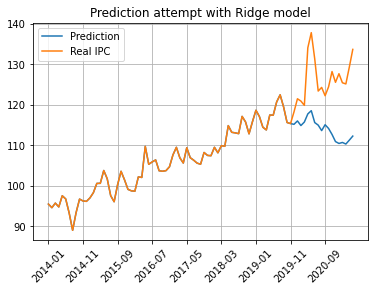

In [35]:
ridge = Ridge(alpha=0.01, random_state=20)
ridge.fit(prices_train, IPC_train.ravel())
Predict = ridge.predict(prices_train)
Predict = np.append(Predict, ridge.predict(prices_test))
Graph(Predict, IPC, 'Ridge model')

RMSE on test set: 4.731436787471418
RMSE on train set: 0.00040745112212326205
(88,)


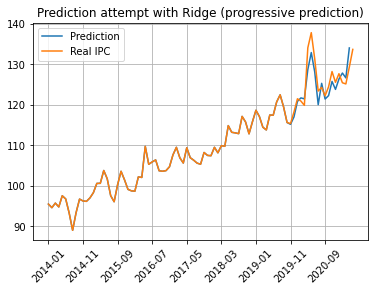

In [36]:
parameters = {'alpha':0.01, 'random_state':20}
Predict = Prediction_monthly(Ridge, parameters, IPC_test, IPC_train, prices_test, prices_train)
print(Predict.shape)
Graph(Predict, IPC, 'Ridge (progressive prediction)')

The Ridge model stays in the right values but doesn't get the right variations, even with the progressive prediction.

## L1 Regularisation : Lasso model

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.031617737294203, tolerance: 0.4398225554929578
  model = cd_fast.enet_coordinate_descent(


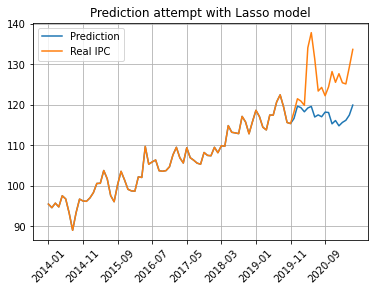

RMSE on test set: 10.124338563269745
RMSE on train set: 0.016625491974346544


In [39]:
lasso = Lasso(alpha=0.0009, random_state=20)
lasso.fit(prices_train, IPC_train.ravel())
Predict = lasso.predict(prices_train)
RMSE_train = mean_squared_error(IPC_train, Predict, squared = False)
Predict = np.append(Predict, lasso.predict(prices_test))
Graph(Predict, IPC, 'Lasso model')

RMSE_test = mean_squared_error(IPC_test, Predict[-len(IPC_test):], squared = False)


print(f'RMSE on test set: {RMSE_test}')
print(f'RMSE on train set: {RMSE_train}')

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.031617737294203, tolerance: 0.4398225554929578
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.031617737294203, tolerance: 0.4398225554929578
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.005608540593321, tolerance: 0.45495263944444453
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergen

RMSE on test set: 5.363659159541833
RMSE on train set: 0.019648257096465685
(88,)


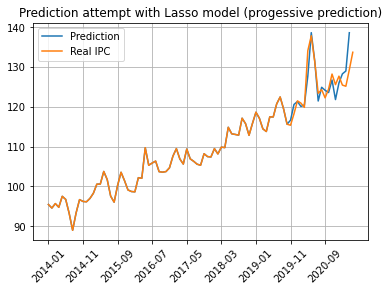

In [41]:
parameters = {'alpha':0.0009, 'random_state':20}
Predict = Prediction_monthly(Lasso, parameters, IPC_test, IPC_train, prices_test, prices_train)
print(Predict.shape)
Graph(Predict, IPC, 'Lasso model (progessive prediction)')

The Lasso model has the same problem as the Ridge one.

# With t-1 point

Let's try giving to our data one old point. We have to lose one sample but as the CPI is continue we can imagine that the result will be better anyway.


In [43]:
X2 = np.column_stack([prices_monthly[1:], np.transpose(IPC[:-1])])
IPC2 = IPC[1:]

IPC2_train = X2[:int(len(IPC2)*.8)]
IPC2_test = X2[:int(len(IPC2)*.8)]

X2_train = X2[:len(IPC2_train)]
X2_test = X2[len(IPC2_test):]

In [32]:
def Prediction2(model, parameter, variation_list):
    Model = model
    n_list = variation_list
    tuned_parameters = {parameter: n_list}
    nb_folds = 5
    grid = GridSearchCV(Model, tuned_parameters, cv=nb_folds, refit=True, scoring='r2')
    grid.fit(X2_train, IPC2_train)
    print(f'Best model found : {grid.best_estimator_}')
    Model = grid.best_estimator_
    Predict_test = Model.predict(X2_test)
    Predict = Model.predict(X2)
    Predict_train = Model.predict(X2_train)
    
    RMSE_test = mean_squared_error(IPC2_test, Predict_test, squared = False)
    RMSE_train = mean_squared_error(IPC2_train, Predict_train, squared = False)

    print(f'RMSE on test set: {RMSE_test}')
    print(f'RMSE on train set: {RMSE_train}')

    return Predict, RMSE_test, RMSE_train

Best model found : DecisionTreeRegressor(max_depth=15)
RMSE on test set: 11.776326063571593
RMSE on train set: 0.0


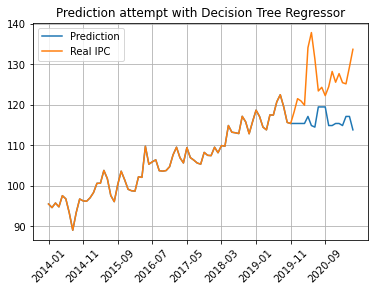

In [34]:
Predict, RMSE_test_DTR, RMSE_trian_DTR = Prediction(DecisionTreeRegressor(), 'max_depth', np.arange(5, 30, 1))
Graph(Predict, IPC2, 'Decision Tree Regressor')

Best model found : DecisionTreeRegressor(max_depth=13)
RMSE on test set: 11.565310679402918
RMSE on train set: 0.0


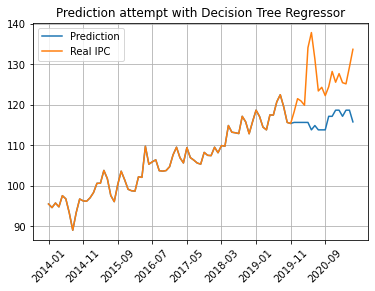

In [36]:
Predict, RMSE_test_DTR, RMSE_trian_DTR = Prediction(DecisionTreeRegressor(), 'max_depth', np.arange(5, 30, 1))
Graph(Predict, IPC, 'Decision Tree Regressor')

Best model found : GradientBoostingRegressor(n_estimators=150)
RMSE on test set: 14.458233102109824
RMSE on train set: 0.005164451810964121


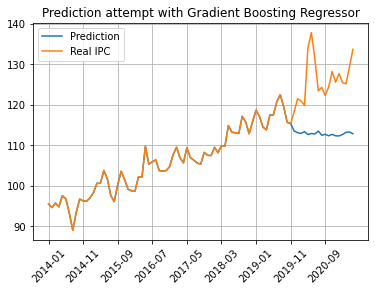

In [35]:
Predict, RMSE_test_GBR0, RMSE_trian_GBR0 = Prediction(GradientBoostingRegressor(), 'n_estimators', np.arange(50, 500, 50))
Graph(Predict, IPC, 'Gradient Boosting Regressor')

# Conclusion

The best model is seemed to be the Gradient Boosting Regressor, with the right parameter values and the progressive prediction. We are still far away from having a really precise prediction on the IPC.